# 0 Importing Modules

In [1]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from rnn_data import RNNDataLoader
from rnn_models import RNNForecastModel, IVS_RNN, IVS_LSTM, IVS_GRU
import torch
from torch.nn import ELU, Linear, LSTM, GRU, Dropout, MSELoss
from torch.optim import Adam

Excerpt from Medvedev 2019: "GARCH family models tend to produce a term structure that reverts to the
long-term mean (Sinclair, 2013) and fails to capture the volatility skew (Dupire, 1994)...

Hansen and Lunde (2005), tested over 330 GARCH
family models, seeking to identify advantages of the more sophisticated models to a
standard GARCH(1,1) model...

The research found no evidence that more sophisticated
GARCH models significantly outperform the standard GARCH(1,1) model."

For each of the RNN architectures: 
    
    1. Define the a model that takes in historical returns and outputs an IV surface for a range of discrete moneyness and maturity
    
    2. Calculate a Black-Scholes option pricing for each of these IV's on the surface
    
    3. Find the loss of the pricing with respect to the realized pricing and backpropogate through the model for training


As extension I can also add market IV surface to model (b) input

# 1 Preparing Data

## 1.1 Downloading Data to Dataframes

In [37]:
"""
Making training, and testing datasets
Training set is SPY returns from 2014 to 2019
Testing set is SPY returns in 2019 
"""
# Defining start date, split date, and end date of data to be used for the model
start_date = "2012-01-01"
split_date = "2019-01-01"
end_date = "2020-01-01"

# Defining range of discrete maturities and moneynesses for IV to be predicted for in the model
maturities = list(range(21, 253, 21))
moneynesses = np.linspace(0.8, 1.2, 21)

# Constructing the data loader
model_data_loader = RNNDataLoader("SPY", maturities, moneynesses, start_date, end_date, split_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
c:\Users\Tayo\Documents\Forecasting-Implied-Volatility-with-Machine-Learning-Techniques\distributions.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\Tayo\Documents\Forecasting-Implied-Volatility-with-Machine-Learning-Techniques\distributions.py:93: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

[*********************100%%**********************]  1 of 1 completed
[*********************100%%*************

<Axes: xlabel='Date'>

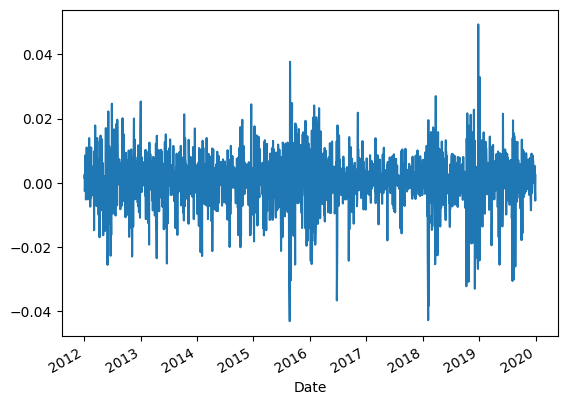

In [38]:
model_data_loader.data["Log Returns"].plot()

## 1.2 Creating Training and Testing Data

### 1.2.0 Defining Model Input and Output Dimensions

Here I define the number of timesteps of returns the model expects, and also the number of timesteps of implied volatility the model will predict, along with the dimensions of the implied volatility surface the model will output

In [39]:
input_timesteps = 60
output_timesteps = 1

### 1.2.1 Constructing Training Data

In [40]:
X_train, y_train, bs_info = model_data_loader.train_data(input_timesteps, output_timesteps)

In [41]:
print(f"Input shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
for key in bs_info.keys():
    print(f"BS input information shape: {bs_info[key].shape}")

Input shape: (1697, 60, 1)
Target shape: (1697, 1, 12, 21, 2)
BS input information shape: (1697, 1, 12, 21, 1)
BS input information shape: (1697, 1, 12, 21, 1)
BS input information shape: (1697, 1, 12, 21, 1)
BS input information shape: (1697, 1, 12, 21, 1)
BS input information shape: (1697, 1, 12, 21, 1)


### 1.3.1 Constructing Testing Data

In [42]:
X_test, y_test, bs_test_info = model_data_loader.test_data(input_timesteps, output_timesteps)

In [43]:
print(f"Input shape: {X_test.shape}")
print(f"Target shape: {y_test.shape}")
for key in bs_test_info.keys():
    print(f"BS input information shape: {bs_test_info[key].shape}")

Input shape: (191, 60, 1)
Target shape: (191, 1, 12, 21, 2)
BS input information shape: (191, 1, 12, 21, 1)
BS input information shape: (191, 1, 12, 21, 1)
BS input information shape: (191, 1, 12, 21, 1)
BS input information shape: (191, 1, 12, 21, 1)
BS input information shape: (191, 1, 12, 21, 1)


# 2 LSTM Models

## 2.1 Training Model

In [44]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device for model")

# LSTM Layers including dropout regularization
# In this architecture, the LSTM can be interpreted as outputting two values for each 
# output timestep, and then forwarding this to a feedforward linear network that 
# turns this information into an IV surface
class IVS_LSTM(torch.nn.Module):
    def __init__(self, features, hidden_size, output_timesteps, num_layers, num_maturities, num_moneynesses, proj_size=0, batch_first=True, dropout=0):
        super(IVS_LSTM, self).__init__()
        self.lstm = LSTM(input_size=features, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, dropout=dropout, proj_size=proj_size)
        self.lin = Linear(proj_size if proj_size != 0 else hidden_size, output_timesteps*num_maturities*num_moneynesses*2)
        self.elu = ELU()
    
    def forward(self, input: torch.Tensor) -> tuple[torch.Tensor, tuple[torch.Tensor, torch.Tensor]]:
        lstm_out, h_out = self.lstm(input)
        lin_out = self.lin(lstm_out[:, -1])
        # Activation to ensure volatility output is greater than 0
        out = self.elu(lin_out) + 1
        return out, h_out
    
    @staticmethod
    # Defining black-scholes function to take model output IVs and output Option Prices to compare to target prices
    def bs_fn(call, S, K, r, v, t, q):
        cdf = torch.distributions.Normal(0, 1).cdf

        d1 = (torch.log(S/K) + (r - q + (v**2)/2)*t) / (v * (t**0.5))
        d2 = d1 - (v * (t**0.5))

        if call:
            ov = S*torch.exp(-q*t)*cdf(d1) - K*torch.exp(-r*t)*cdf(d2)
        else:
            ov = K*torch.exp(-r*t)*cdf(-d2) - S*torch.exp(-q*t)*cdf(-d1)
        
        return ov

lstm_model = IVS_LSTM(1, output_timesteps*len(maturities)*4, output_timesteps, 1, len(maturities), len(moneynesses), dropout=0.2).to(device)

loss_fn = MSELoss()
opt = Adam(lstm_model.parameters())

Using CUDA device for model


c:\Users\Tayo\Documents\Forecasting-Implied-Volatility-with-Machine-Learning-Techniques\.venv\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



In [45]:
epochs = 500
batch_size = 32

losses = []

lstm_model.train()

for i in range(epochs):
    for x_, y_, bs_info_ in model_data_loader.batch_gen(X_train, y_train, bs_info, batch_size):
        # Putting data in device
        x_ = torch.tensor(x_).to(torch.float32).to(device)
        y_ = torch.tensor(y_).to(torch.float32).to(device)
        for key in bs_info_.keys():
            bs_info_[key] = torch.tensor(bs_info_[key]).to(torch.float32).to(device)

        opt.zero_grad()

        output, h_out = lstm_model(x_)
        output = output.reshape(-1, y_.shape[1], y_.shape[2], y_.shape[3], y_.shape[4])

        # Calculating Black-Scholes option prices based on model iv surface and other contemporary info
        call_prices = IVS_LSTM.bs_fn(call=True, v=torch.unsqueeze(output[:,:,:,:,0], -1), **bs_info_)
        put_prices = IVS_LSTM.bs_fn(call=False, v=torch.unsqueeze(output[:,:,:,:,1], -1), **bs_info_)
        price_output = torch.cat((call_prices, put_prices), -1)

        loss = loss_fn(price_output, y_)
        loss.backward()

        losses.append(torch.detach(loss).cpu())

        opt.step()
    print(f"Epoch {i+1}/{epochs} - loss: {loss}")

Epoch 1/500 - loss: 483.6366882324219
Epoch 2/500 - loss: 422.9698181152344
Epoch 3/500 - loss: 412.5218505859375
Epoch 4/500 - loss: 410.7297058105469
Epoch 5/500 - loss: 410.02215576171875
Epoch 6/500 - loss: 409.7460632324219
Epoch 7/500 - loss: 409.6184387207031
Epoch 8/500 - loss: 409.55596923828125
Epoch 9/500 - loss: 409.5276184082031
Epoch 10/500 - loss: 409.5190734863281
Epoch 11/500 - loss: 409.52264404296875
Epoch 12/500 - loss: 409.53363037109375
Epoch 13/500 - loss: 409.5481262207031
Epoch 14/500 - loss: 409.5630798339844
Epoch 15/500 - loss: 409.5766296386719
Epoch 16/500 - loss: 409.587646484375
Epoch 17/500 - loss: 409.5957946777344
Epoch 18/500 - loss: 409.6015930175781
Epoch 19/500 - loss: 409.6050720214844
Epoch 20/500 - loss: 409.5689697265625
Epoch 21/500 - loss: 409.5503845214844
Epoch 22/500 - loss: 409.54229736328125
Epoch 23/500 - loss: 409.5408935546875
Epoch 24/500 - loss: 409.5425720214844
Epoch 25/500 - loss: 409.5445556640625
Epoch 26/500 - loss: 409.54562

Text(0.5, 0, 'Batch Number')

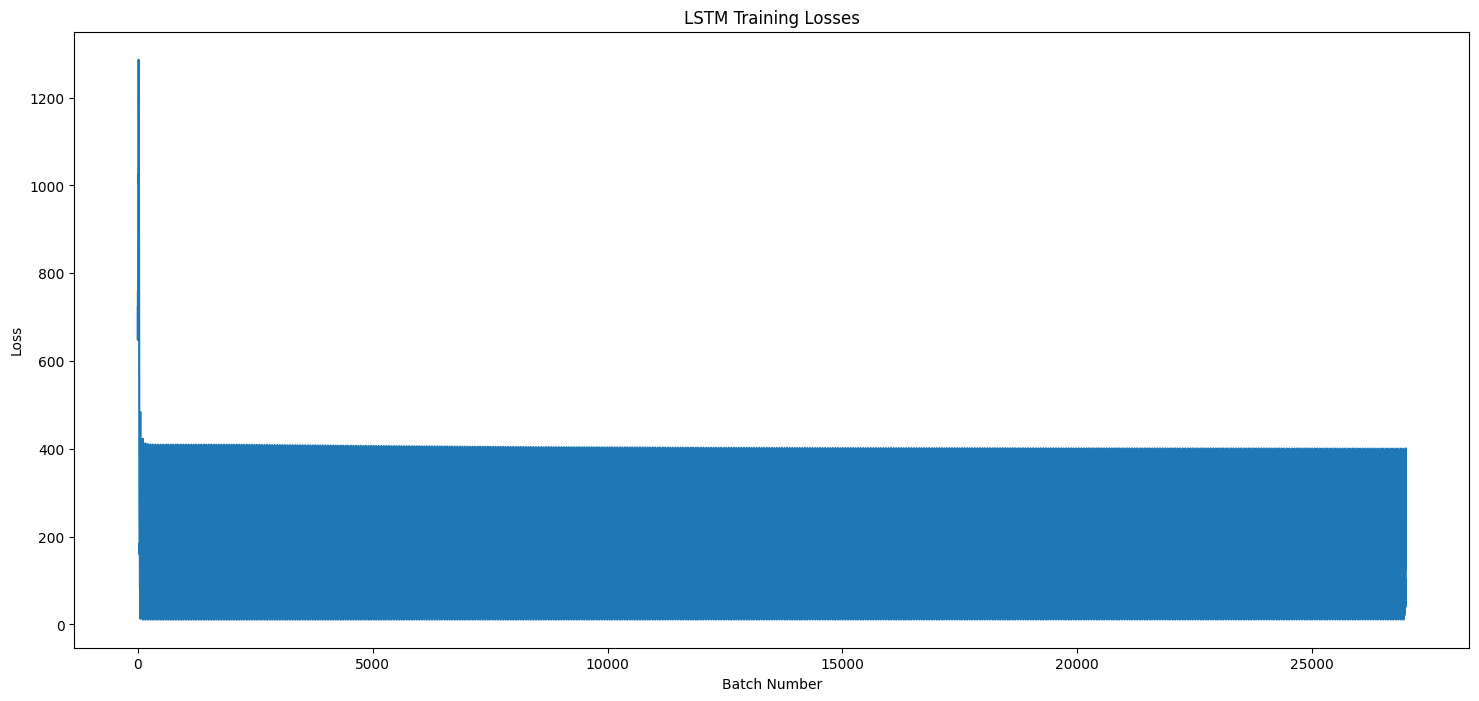

In [46]:
fig = plt.figure(figsize=(18,8))
plt.plot(range(len(losses)), [loss.cpu() for loss in losses])
plt.title("LSTM Training Losses")
plt.ylabel("Loss")
plt.xlabel("Batch Number")

## 2.2 Testing Model on Holdout Data

In [47]:
lstm_model.eval()

test_losses = []

for x_, y_, bs_info_ in model_data_loader.batch_gen(X_test, y_test, bs_test_info, batch_size):
        # Putting data in device
        x_ = torch.tensor(x_).to(torch.float32).to(device)
        y_ = torch.tensor(y_).to(torch.float32).to(device)
        for key in bs_info_.keys():
            bs_info_[key] = torch.tensor(bs_info_[key]).to(torch.float32).to(device)

        output, h_out = lstm_model(x_)
        output = output.reshape(-1, y_.shape[1], y_.shape[2], y_.shape[3], y_.shape[4])

        # Calculating Black-Scholes option prices based on model iv surface and other contemporary info
        call_prices = IVS_LSTM.bs_fn(call=True, v=torch.unsqueeze(output[:,:,:,:,0], -1), **bs_info_)
        put_prices = IVS_LSTM.bs_fn(call=False, v=torch.unsqueeze(output[:,:,:,:,1], -1), **bs_info_)
        price_output = torch.cat((call_prices, put_prices), -1)

        loss = loss_fn(price_output, y_)

        test_losses.append(torch.detach(loss).cpu())

Text(0.5, 0, 'Batch Number')

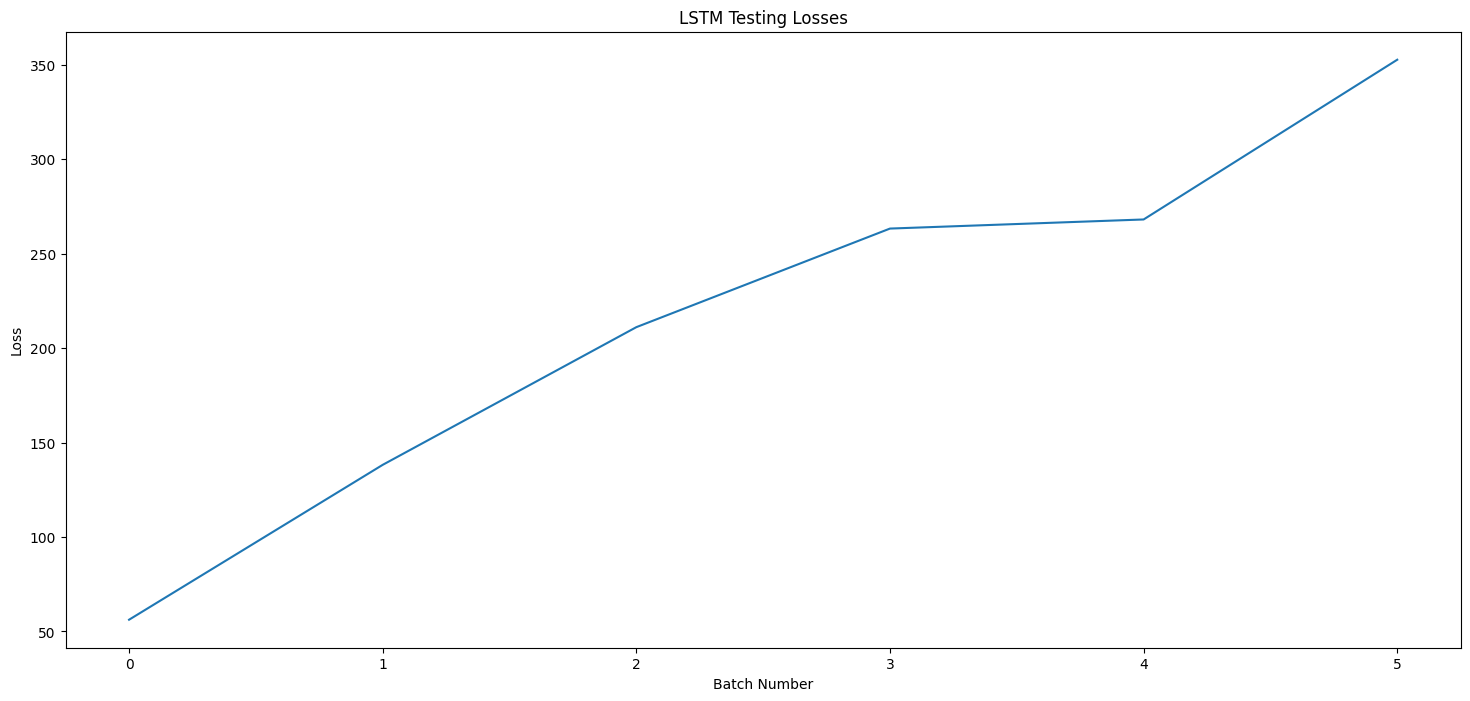

In [48]:
fig = plt.figure(figsize=(18,8))
plt.plot(range(len(test_losses)), test_losses)
plt.title("LSTM Testing Losses")
plt.ylabel("Loss")
plt.xlabel("Batch Number")

In [69]:
ivs, _ = lstm_model(torch.tensor(X_test).to(torch.float32).to(device))
ivs = torch.reshape(ivs, (-1, 1, 12, 21, 2))
i = 22
t = 0

fig = go.Figure(data=[
    go.Surface(
        x=moneynesses,
        y=maturities,
        z=ivs[i, t, :, :, 0].cpu().detach().numpy()
        )
])

fig.show()

# 3 GRU Models 

## 3.1 Training Model

In [50]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device for model")

class IVS_GRU(torch.nn.Module):
    def __init__(self, features, hidden_size, output_timesteps, num_layers, num_maturities, num_moneynesses, batch_first=True, dropout=0):
        super(IVS_GRU, self).__init__()
        self.lstm = GRU(input_size=features, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, dropout=dropout)
        self.lin = Linear(hidden_size, output_timesteps*num_maturities*num_moneynesses*2)
        self.elu = ELU()
    
    def forward(self, input: torch.Tensor) -> tuple[torch.Tensor, tuple[torch.Tensor, torch.Tensor]]:
        lstm_out, h_out = self.lstm(input)
        lin_out = self.lin(lstm_out[:, -1])
        # Activation to ensure volatility output is greater than 0
        out = self.elu(lin_out) + 1
        return out, h_out
    
    @staticmethod
    # Defining black-scholes function to take model output IVs and output Option Prices to compare to target prices
    def bs_fn(call, S, K, r, v, t, q):
        cdf = torch.distributions.Normal(0, 1).cdf

        d1 = (torch.log(S/K) + (r - q + (v**2)/2)*t) / (v * (t**0.5))
        d2 = d1 - (v * (t**0.5))

        if call:
            ov = S*torch.exp(-q*t)*cdf(d1) - K*torch.exp(-r*t)*cdf(d2)
        else:
            ov = K*torch.exp(-r*t)*cdf(-d2) - S*torch.exp(-q*t)*cdf(-d1)
        
        return ov

gru_model = IVS_GRU(1, output_timesteps*len(maturities)*4, output_timesteps, 1, len(maturities), len(moneynesses), dropout=0.2).to(device)

loss_fn = MSELoss()
opt = Adam(gru_model.parameters())

Using CUDA device for model


In [51]:
epochs = 500
batch_size = 32

losses = []

gru_model.train()

for i in range(epochs):
    for x_, y_, bs_info_ in model_data_loader.batch_gen(X_train, y_train, bs_info, batch_size):
        # Putting data in device
        x_ = torch.tensor(x_).to(torch.float32).to(device)
        y_ = torch.tensor(y_).to(torch.float32).to(device)
        for key in bs_info_.keys():
            bs_info_[key] = torch.tensor(bs_info_[key]).to(torch.float32).to(device)

        opt.zero_grad()

        output, h_out = gru_model(x_)
        output = output.reshape(-1, y_.shape[1], y_.shape[2], y_.shape[3], y_.shape[4])

        # Calculating Black-Scholes option prices based on model iv surface and other contemporary info
        call_prices = IVS_GRU.bs_fn(call=True, v=torch.unsqueeze(output[:,:,:,:,0], -1), **bs_info_)
        put_prices = IVS_GRU.bs_fn(call=False, v=torch.unsqueeze(output[:,:,:,:,1], -1), **bs_info_)
        price_output = torch.cat((call_prices, put_prices), -1)

        loss = loss_fn(price_output, y_)
        loss.backward()

        losses.append(torch.detach(loss).cpu())

        opt.step()
    print(f"Epoch {i+1}/{epochs} - loss: {loss}")

Epoch 1/500 - loss: 499.71661376953125
Epoch 2/500 - loss: 424.7888488769531
Epoch 3/500 - loss: 413.5872497558594
Epoch 4/500 - loss: 411.7196044921875
Epoch 5/500 - loss: 410.9403991699219
Epoch 6/500 - loss: 410.5544128417969
Epoch 7/500 - loss: 410.327880859375
Epoch 8/500 - loss: 409.7655334472656
Epoch 9/500 - loss: 409.6769714355469
Epoch 10/500 - loss: 409.4709777832031
Epoch 11/500 - loss: 409.3864440917969
Epoch 12/500 - loss: 409.3202819824219
Epoch 13/500 - loss: 409.2597961425781
Epoch 14/500 - loss: 409.2262268066406
Epoch 15/500 - loss: 409.2096862792969
Epoch 16/500 - loss: 409.19696044921875
Epoch 17/500 - loss: 409.186279296875
Epoch 18/500 - loss: 409.17529296875
Epoch 19/500 - loss: 409.16485595703125
Epoch 20/500 - loss: 409.1531677246094
Epoch 21/500 - loss: 409.14263916015625
Epoch 22/500 - loss: 409.13055419921875
Epoch 23/500 - loss: 409.1195068359375
Epoch 24/500 - loss: 409.10565185546875
Epoch 25/500 - loss: 409.09283447265625
Epoch 26/500 - loss: 409.076293

Text(0.5, 0, 'Batch Number')

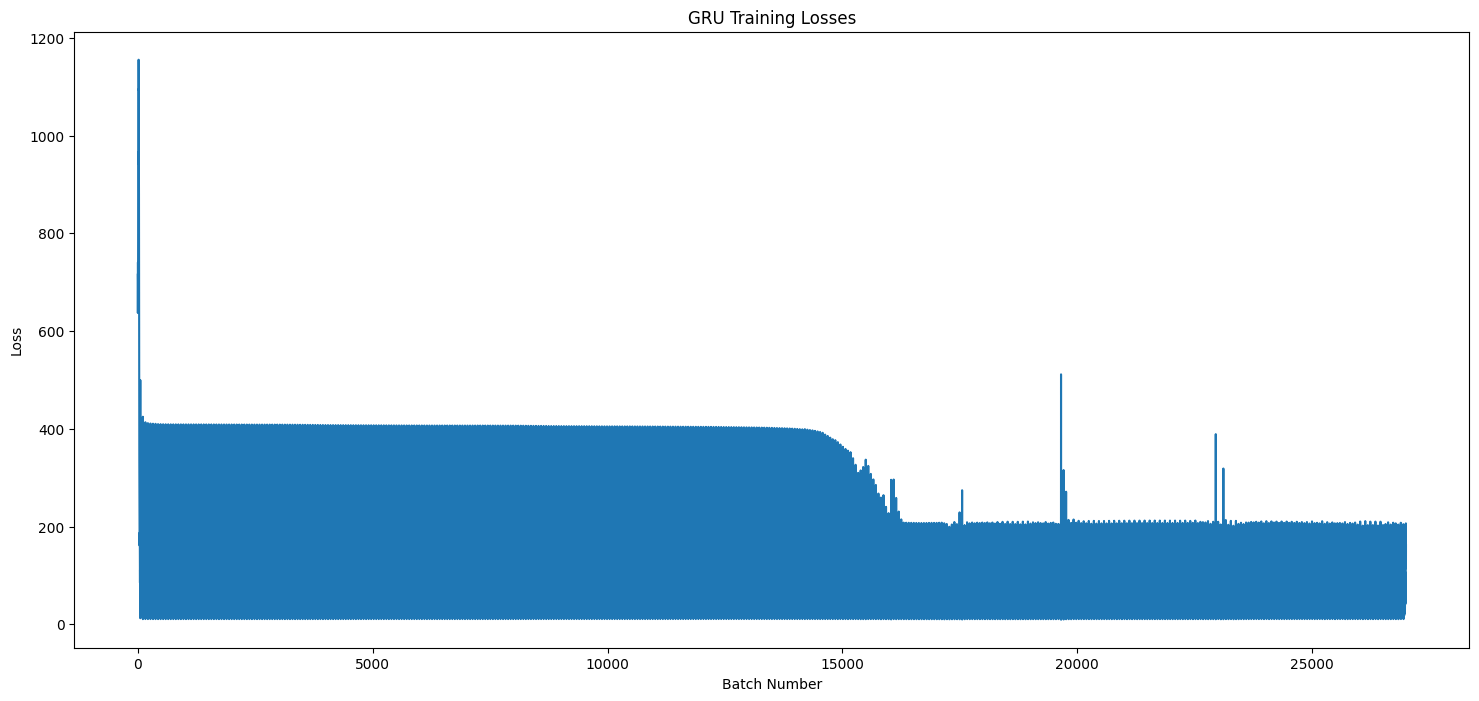

In [52]:
fig = plt.figure(figsize=(18,8))
plt.plot(range(len(losses)), [loss.cpu() for loss in losses])
plt.title("GRU Training Losses")
plt.ylabel("Loss")
plt.xlabel("Batch Number")

## 3.2 Testing on Holdout Data

In [53]:
gru_model.eval()

test_losses = []

for x_, y_, bs_info_ in model_data_loader.batch_gen(X_test, y_test, bs_test_info, batch_size):
        # Putting data in device
        x_ = torch.tensor(x_).to(torch.float32).to(device)
        y_ = torch.tensor(y_).to(torch.float32).to(device)
        for key in bs_info_.keys():
            bs_info_[key] = torch.tensor(bs_info_[key]).to(torch.float32).to(device)

        output, h_out = gru_model(x_)
        output = output.reshape(-1, y_.shape[1], y_.shape[2], y_.shape[3], y_.shape[4])

        # Calculating Black-Scholes option prices based on model iv surface and other contemporary info
        call_prices = IVS_GRU.bs_fn(call=True, v=torch.unsqueeze(output[:,:,:,:,0], -1), **bs_info_)
        put_prices = IVS_GRU.bs_fn(call=False, v=torch.unsqueeze(output[:,:,:,:,1], -1), **bs_info_)
        price_output = torch.cat((call_prices, put_prices), -1)

        loss = loss_fn(price_output, y_)

        test_losses.append(torch.detach(loss).cpu())

Text(0.5, 0, 'Batch Number')

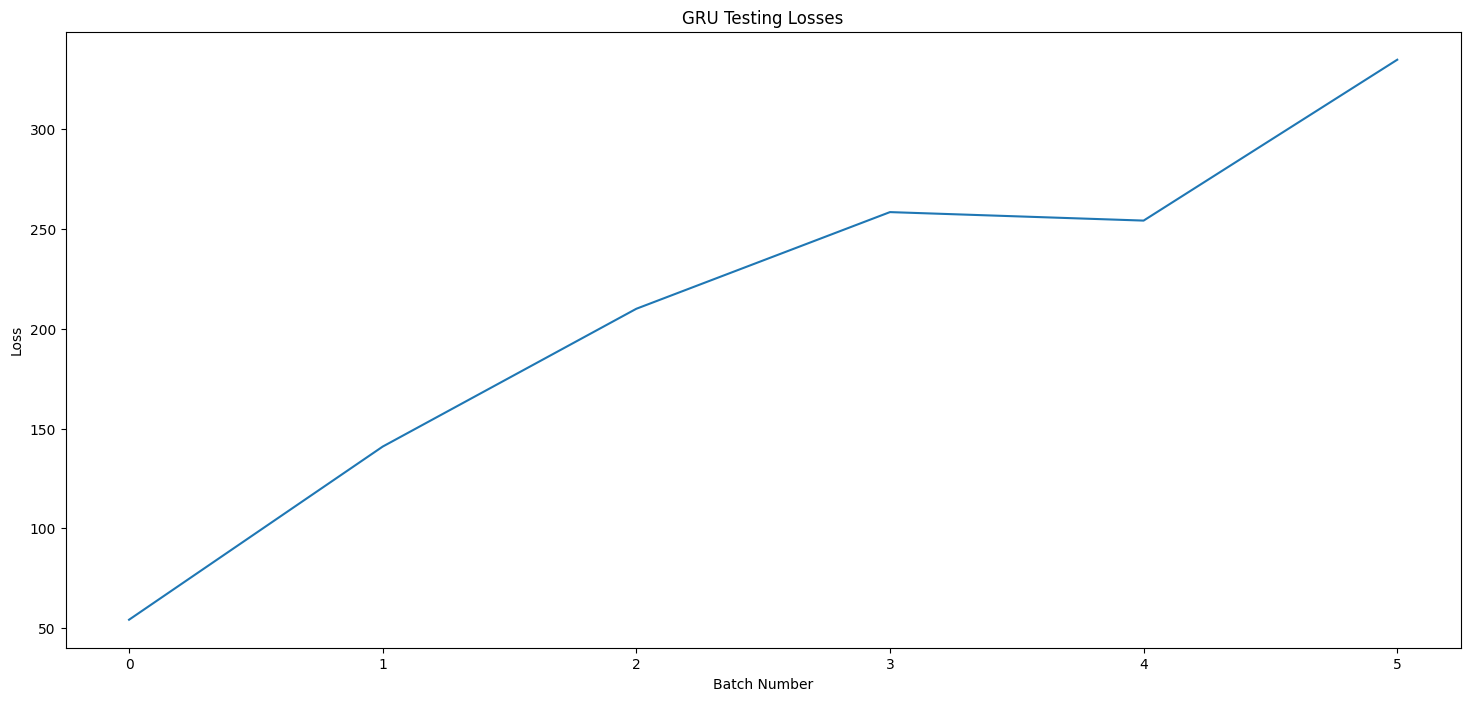

In [54]:
fig = plt.figure(figsize=(18,8))
plt.plot(range(len(test_losses)), test_losses)
plt.title("GRU Testing Losses")
plt.ylabel("Loss")
plt.xlabel("Batch Number")

In [66]:
ivs, _ = gru_model(torch.tensor(X_test).to(torch.float32).to(device))
ivs = torch.reshape(ivs, (-1, 1, 12, 21, 2))
i = 100
t = 0

fig = go.Figure(data=[
    go.Surface(z=ivs[i, t, :, :, 1].cpu().detach().numpy())
])

fig.show()

# 4 Comparing Forecasts to Realized Data

In [2]:
# Defining range of discrete maturities and moneynesses for IV to be predicted for in the model
maturities = list(range(21, 253, 21))
moneynesses = np.linspace(0.8, 1.2, 21)

forecaster = RNNForecastModel(
    "SPY", "2014-01-01", "2020-01-01", "2019-01-01", maturities, moneynesses,
    len(maturities)*4, 1, IVS_GRU
    )

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
c:\Users\Tayo\Documents\Forecasting-Implied-Volatility-with-Machine-Learning-Techniques\distributions.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Realized Call Value"][data["Realized Call Value"] < 0] = 0
c:\Users\Tayo\Documents\Forecasting-Implied-Volatility-with-Machine-Learning-Techniques\distributions.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

Using CUDA for model computations


In [3]:
train_losses = forecaster.train(250, 32, 60)

Epoch 1/250 - latest loss: 158.62103271484375
Epoch 2/250 - latest loss: 144.2249298095703
Epoch 3/250 - latest loss: 94.07781982421875
Epoch 4/250 - latest loss: 83.97167205810547
Epoch 5/250 - latest loss: 94.63729858398438
Epoch 6/250 - latest loss: 89.04007720947266
Epoch 7/250 - latest loss: 82.18157196044922
Epoch 8/250 - latest loss: 100.3933334350586
Epoch 9/250 - latest loss: 78.64643859863281
Epoch 10/250 - latest loss: 70.13678741455078
Epoch 11/250 - latest loss: 122.93181610107422
Epoch 12/250 - latest loss: 70.93183135986328
Epoch 13/250 - latest loss: 70.100830078125
Epoch 14/250 - latest loss: 61.15023422241211
Epoch 15/250 - latest loss: 114.76980590820312
Epoch 16/250 - latest loss: 71.56133270263672
Epoch 17/250 - latest loss: 86.01591491699219
Epoch 18/250 - latest loss: 65.80166625976562
Epoch 19/250 - latest loss: 81.64102935791016
Epoch 20/250 - latest loss: 95.31986999511719
Epoch 21/250 - latest loss: 97.53778839111328
Epoch 22/250 - latest loss: 65.31722259521

In [4]:
options = forecaster.options_pricing(60)

In [9]:
options.loc[0]

,index,Call Price,Put Price,Call IV,Put IV,Dividend Yield,Annualized Rate,Underlying Price,Strike Price,Tau,DTE,Realized Call Value,Realized Put Value,Moneyness,Date
0,0,0.000685,64.801392,0.213489,0.156459,0.01233,1.02328,260.660828,325.826050,0.083333,21,0.000000,58.049751,0.80,2019-03-29
0,0,0.001123,56.869843,0.197814,0.137200,0.01233,1.02328,260.660828,317.879059,0.083333,21,0.000000,50.113293,0.82,2019-03-29
0,0,0.001685,49.315918,0.180495,0.111656,0.01233,1.02328,260.660828,310.310516,0.083333,21,0.000000,42.554756,0.84,2019-03-29
0,0,0.001929,42.113403,0.159428,0.108629,0.01233,1.02328,260.660828,303.093994,0.083333,21,0.000000,35.347782,0.86,2019-03-29
0,0,0.003673,35.238220,0.144085,0.094311,0.01233,1.02328,260.660828,296.205475,0.083333,21,0.000000,28.468397,0.88,2019-03-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,43.030548,0.005263,0.261410,0.042603,0.01233,1.02328,260.660828,232.732880,1.000000,252,60.673637,0.000000,1.12,2019-03-29
0,0,46.760559,0.006445,0.275330,0.049020,0.01233,1.02328,260.660828,228.649841,1.000000,252,64.692307,0.000000,1.14,2019-03-29
0,0,50.876984,0.006611,0.294990,0.054623,0.01233,1.02328,260.660828,224.707611,1.000000,252,68.572411,0.000000,1.16,2019-03-29
0,0,54.507584,0.003394,0.309814,0.056668,0.01233,1.02328,260.660828,220.899002,1.000000,252,72.320976,0.000000,1.18,2019-03-29
